In [104]:
import numpy as np   # Für die mathematische Grundlagen, die benutzt werden.
import matplotlib.pyplot as plt   # Für die Schaubilder
import tensorflow as tf   # Für die Implementierung von Machine Learning und Tensorflow
import rhodium    # Rhobust Decision Making
import scipy.signal as sig   # Für die Signalverarbeitung
from rhodium import *   # Mehr Rhodium 
import networkx as nx   # Mehr zu Tensorflow
from rhodium import Model, sample_lhs, update, evaluate, sa, DataSet   #...Rhodium
import pandas as pd # Für die Excel Tabellen mit den Preisen
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from numpy import array
import numpy_financial as npf #für NPV

In [105]:
def kosten_Jaehrlich(
    Installierte_Leistung: float = 1000, #[kW]
    Volllaststunden: float = 5000, #[h/a]
    #Ertrag: float = 5000000, #[kWh]
    Energieaufwand: float = 50, #[kWh/kg]
    Wirkungsgrad: float = 0.65, #[EINHEITSLOS]
    Preis_Wasserstoff: float = 8.5, #[EURO/kg]
    Kosten_strom: float = 0.07, #[EURO/kWh]
    Wartungskosten_prozent: float = 0.01, #[EINHEITSLOS] ein Prozent der Investitionskosten
    Investitionskosten: float = 2500, #[EURO/kWel]
        )->float:
    Ertrag = Installierte_Leistung*Volllaststunden
    ''''''
    produktionH2 = Ertrag*Wirkungsgrad/Energieaufwand #[kg/a]
    ''''''
    einnahmen_jaerhlich = produktionH2*Preis_Wasserstoff #[EURO/a]
    ''''''
    betriebskosten = Kosten_strom*Ertrag + + Wartungskosten_prozent*Investitionskosten*1000 #[EURO/a]
    ''''''
    Rueckfluss = einnahmen_jaerhlich-betriebskosten #[EURO/a]
    return Rueckfluss

kosten_Jaehrlich()

177499.99999999994

In [106]:
def kapitalwert(
    Installierte_Leistung: float = 1000, #[kW]
    Volllaststunden: float = 5000, #[h/a]
    #Ertrag: float = 5000000, #[kWh]
    Energieaufwand: float = 50, #[kWh/kg]
    Wirkungsgrad: float = 0.65, #[EINHEITSLOS]
    Preis_Wasserstoff: float = 8.5, #[EURO/kg]
    Kosten_strom: float = 0.07, #[EURO/kWh]
    Wartungskosten_prozent: float = 0.01, #[EINHEITSLOS] ein Prozent der Investitionskosten
    Investitionskosten: float = 2500, #[EURO/kWel]
    Diskontierungssatz: float = 0.02
                )->float: 
    CF_jaehrlich = kosten_Jaehrlich(Installierte_Leistung,Volllaststunden, Energieaufwand, Wirkungsgrad, Preis_Wasserstoff, 
                                   Kosten_strom, Wartungskosten_prozent, Investitionskosten) #[EURO/a]
    CF = [] # [EURO]
    for t in range(20):
         CF.append(CF_jaehrlich)

    NPV = 0; 
    for t in range(1,21):
        NPV += CF_jaehrlich / (1 + Diskontierungssatz) ** t

    NPV = NPV - Investitionskosten*1000
    return NPV

In [107]:
x = kapitalwert()
x

402379.4186659865

In [111]:
## Now we define the model!
def return_model()-> Model:
    model = Model(kapitalwert)
    
    model.parameters = [
        #Parameter("Installierte_Leistung"),
        Parameter("Volllaststunden"),
        Parameter("Energieaufwand"),
        Parameter("Wirkungsgrad"), #
        Parameter("Preis_Wasserstoff"), #
        Parameter("Kosten_strom"), #
        Parameter("Wartungskosten_prozent"), #
        Parameter("Investitionskosten"),
        Parameter("Diskontierungssatz")] #
    
    model.responses = [
        Response("NPV", Response.MAXIMIZE)]
    
    #model.constraints = [Constraint("b >= 0.95")]
    
    model.uncertainties = [UniformUncertainty("Wirkungsgrad", 0.6, 0.67),
                           UniformUncertainty("Preis_Wasserstoff", 7, 10),
                           UniformUncertainty("Kosten_strom", 0.06, 0.09),
                           UniformUncertainty("Wartungskosten_prozent", 0.01, 0.02),
                           UniformUncertainty("Diskontierungssatz", 0.01, 0.03),
                           UniformUncertainty("Volllaststunden", 4500, 5000)
                          ]

    model.levers = [
                    #RealLever("Installierte_Leistung", 990, 1100, length = 1)
                    #RealLever("Volllaststunden", 4500, 5000, length = 1)
                    ]

    return model


model = return_model();

In [185]:
SOWs = sample_lhs(model, 10000)
model_results = evaluate(model, SOWs)

In [187]:
df = pd.DataFrame(model_results)

positive_npv_count = df[df['NPV'] > 0].shape[0]

negative_npv_count = df[df['NPV'] < 0].shape[0]

print(f"Anzahl positive NPV-Werte: {positive_npv_count}")
print(f"Anzahl negative NPV-Werte: {negative_npv_count}")

Anzahl positive NPV-Werte: 3267
Anzahl negative NPV-Werte: 6733


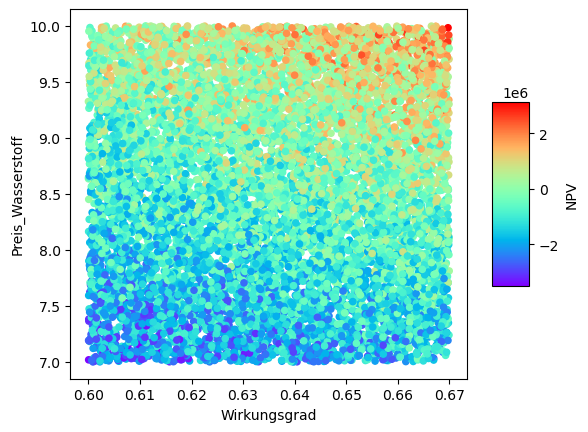

In [113]:
fig1 = scatter2d(model, model_results, x="Wirkungsgrad", y="Preis_Wasserstoff", c = "NPV")

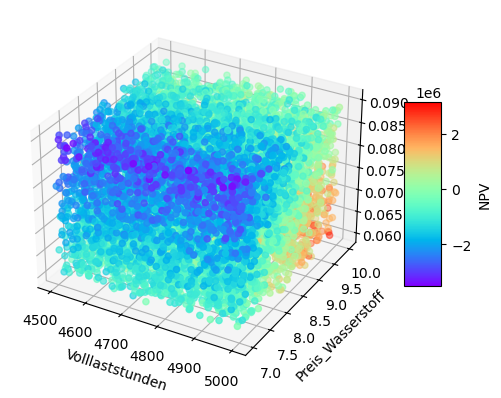

In [114]:
fig3 = scatter3d(model, model_results, x="Volllaststunden", y="Preis_Wasserstoff", z = "Kosten_strom", c = "NPV")

C:\Users\santosch\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


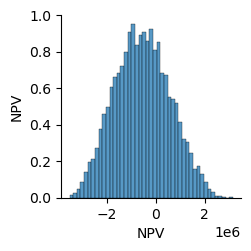

In [143]:
fig6 = pairs(model, model_results, "NPV")

In [117]:
#fig7 = parallel_coordinates(model,model_results, colormap="rainbow", target="top")

C:\Users\santosch\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\santosch\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


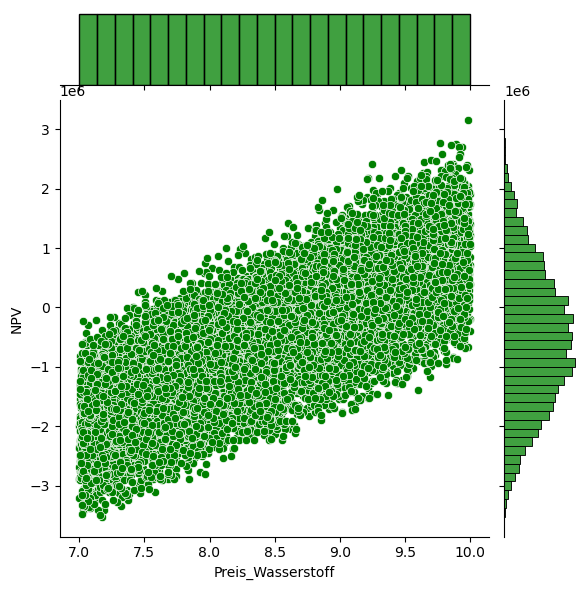

In [118]:
joint(model, model_results, x="Preis_Wasserstoff", y="NPV", color="green")

C:\Users\santosch\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\santosch\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


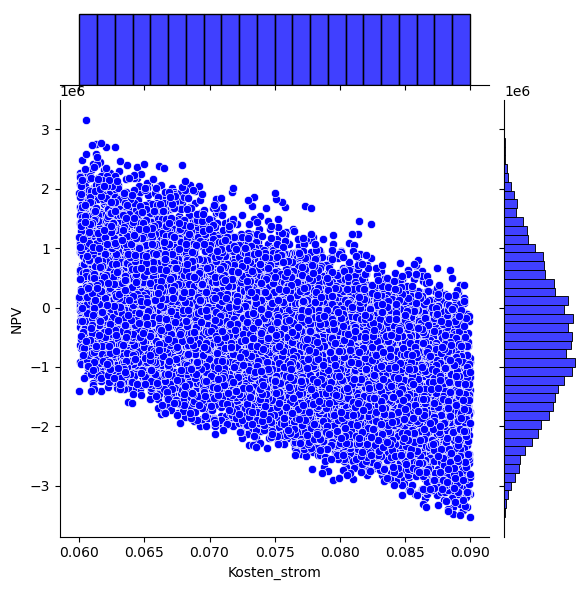

In [122]:
joint(model, model_results, x="Kosten_strom", y="NPV", color="blue")

In [123]:
sa_results = sa(model, "NPV", method="fast", nsamples=1000)
#print(opt_results)
print(sa_results)

First order sensitivity indices (confidence interval):
              Wirkungsgrad: +0.048625 (+0.086527)
         Preis_Wasserstoff: +0.528827 (+0.085145)
              Kosten_strom: +0.430426 (+0.093676)
    Wartungskosten_prozent: +0.022226 (+0.101628)
        Diskontierungssatz: +0.017567 (+0.098113)
           Volllaststunden: +0.007771 (+0.084920)
Total order sensitivity indices (confidence interval):
              Wirkungsgrad: +0.050155 (+0.112063)
         Preis_Wasserstoff: +0.534460 (+0.098483)
              Kosten_strom: +0.432835 (+0.104027)
    Wartungskosten_prozent: +0.023234 (+0.093309)
        Diskontierungssatz: +0.019884 (+0.115005)
           Volllaststunden: +0.009941 (+0.095715)


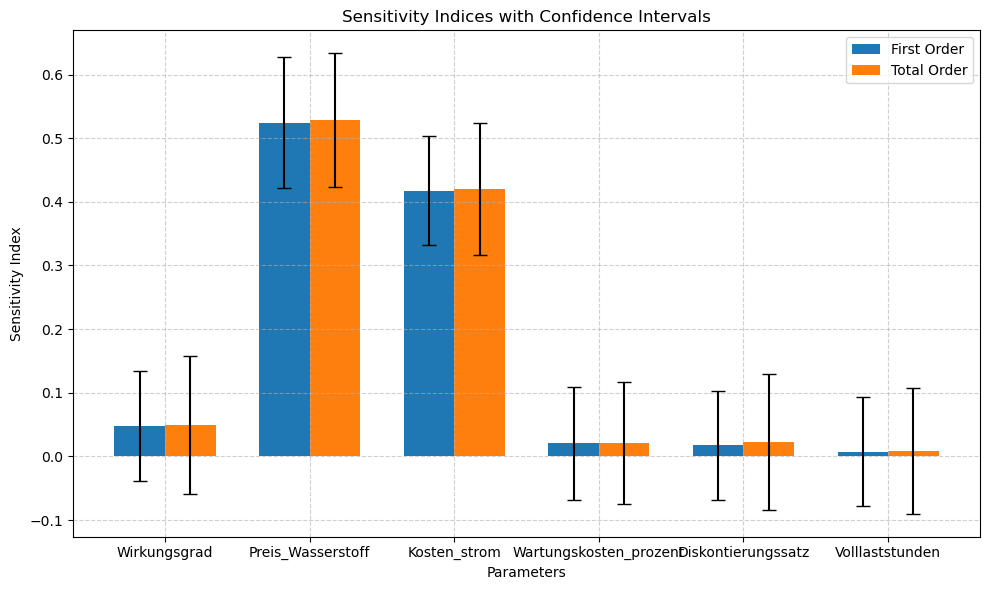

In [125]:
import matplotlib.pyplot as plt
import numpy as np

parameters = [
    "Wirkungsgrad", 
    "Preis_Wasserstoff", 
    "Kosten_strom", 
    "Wartungskosten_prozent", 
    "Diskontierungssatz", 
    "Volllaststunden"
]

first_order_indices = [
    0.047862, 
    0.524243, 
    0.417442, 
    0.020423, 
    0.017241, 
    0.007644
]

first_order_ci = [
    0.086735, 
    0.103154, 
    0.085390, 
    0.088069, 
    0.086212, 
    0.085178
]

total_order_indices = [
    0.049536, 
    0.528453, 
    0.420135, 
    0.020996, 
    0.022184, 
    0.008769
]

total_order_ci = [
    0.108599, 
    0.104796, 
    0.104219, 
    0.096039, 
    0.107027, 
    0.098464
]

fig, ax = plt.subplots(figsize=(10, 6))

width = 0.35

x = np.arange(len(parameters))

bar1 = ax.bar(x - width/2, first_order_indices, width, yerr=first_order_ci, label='First Order', capsize=5)

bar2 = ax.bar(x + width/2, total_order_indices, width, yerr=total_order_ci, label='Total Order', capsize=5)

ax.set_xlabel('Parameters')
ax.set_ylabel('Sensitivity Index')
ax.set_title('Sensitivity Indices with Confidence Intervals')
ax.set_xticks(x)
ax.set_xticklabels(parameters)
ax.legend()

ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()



### Chatpt: 
In Rhodium, the kdeplot function is used to create Kernel Density Estimate (KDE) plots. KDE plots are a way to visualize the probability density function of a continuous variable. This function provides a smooth estimate of the data distribution, making it easier to see the underlying patterns compared to using histograms.

C:\Users\santosch\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\santosch\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


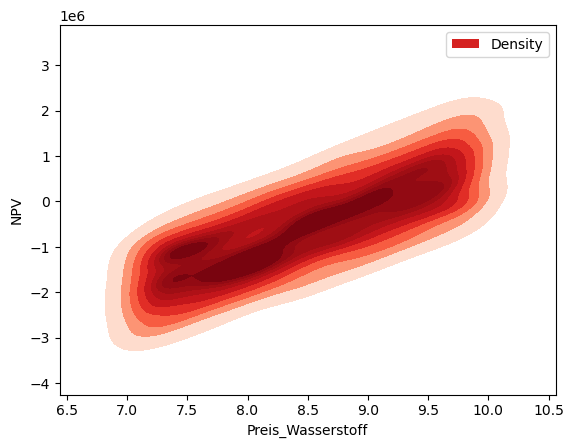

In [134]:
kdeplot(model, model_results, x="Preis_Wasserstoff", y="NPV")

C:\Users\santosch\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\santosch\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


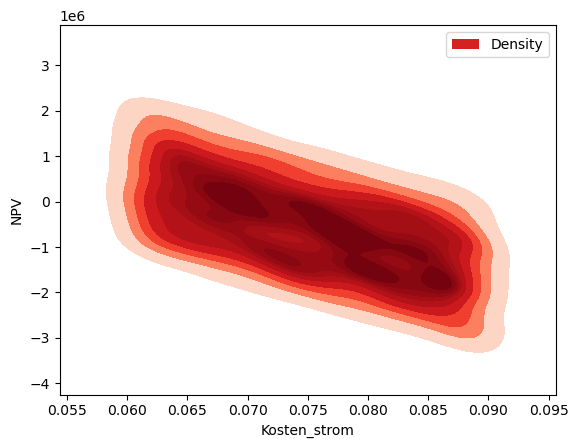

In [146]:
kdeplot(model, model_results, x="Kosten_strom", y="NPV")

### CHATGPT:
The function contour3d is used to create a 3D contour plot from a model's results in Rhodium. This function takes various inputs to specify the model, data, and plot attributes, and then generates a 3D surface plot with contour levels.

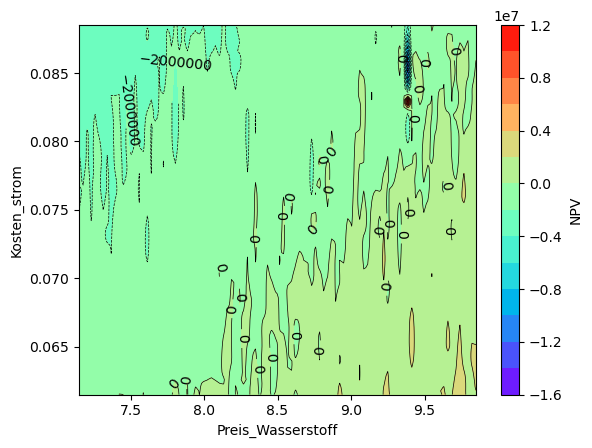

In [183]:
fig =contour2d(model, model_results, x= "Preis_Wasserstoff", y = "Kosten_strom", z = "NPV")

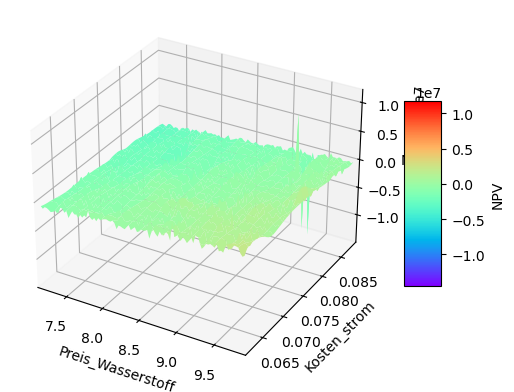

In [182]:
fig_contour = contour3d(model, model_results, x= "Preis_Wasserstoff", y = "Kosten_strom", z = "NPV")

### CHATGPT: 
Die Funktion regret_type1 berechnet die Typ-1-Reue, indem sie die prozentualen Abweichungen der Ergebnisse von einem Basiswert für jede relevante Antwort des Modells ermittelt. Sie gibt dann das größte dieser Perzentile zurück, was die höchste Reue darstellt.

In [199]:
baseline_NPV = {'NPV': 400000}
regret_type1(model,model_results, baseline_NPV)

6.123855879291707